In [44]:
import onnx
import onnxruntime

# Load the ONNX model
model_path = 'CNN_C52v_2023March21.onnx'
onnx_model = onnx.load(model_path)

# Check that the model is well formed
onnx.checker.check_model(onnx_model)

# Print a human-readable representation of the model graph
print("Model Architecture:")
print(onnx.helper.printable_graph(onnx_model.graph))

# Optionally, iterate through the nodes to see details (note that weights are stored as initializers)
print("\nModel Weights and Parameters:")
for initializer in onnx_model.graph.initializer:
    print(f"Name: {initializer.name}, Shape: {onnx.numpy_helper.to_array(initializer).shape}")

Model Architecture:
graph Network (
  %data[FLOAT, BatchSizex3x256x1024]
) initializers (
  %data_Mean[FLOAT, 1x3x1x1]
  %data_StandardDeviation[FLOAT, 1x3x1x1]
  %conv1_W[FLOAT, 64x3x7x7]
  %conv1_B[FLOAT, 64]
  %bn_conv1_scale[FLOAT, 64]
  %bn_conv1_B[FLOAT, 64]
  %bn_conv1_mean[FLOAT, 64]
  %bn_conv1_var[FLOAT, 64]
  %res2a_branch2a_W[FLOAT, 64x64x3x3]
  %res2a_branch2a_B[FLOAT, 64]
  %bn2a_branch2a_scale[FLOAT, 64]
  %bn2a_branch2a_B[FLOAT, 64]
  %bn2a_branch2a_mean[FLOAT, 64]
  %bn2a_branch2a_var[FLOAT, 64]
  %res2a_branch2b_W[FLOAT, 64x64x3x3]
  %res2a_branch2b_B[FLOAT, 64]
  %bn2a_branch2b_scale[FLOAT, 64]
  %bn2a_branch2b_B[FLOAT, 64]
  %bn2a_branch2b_mean[FLOAT, 64]
  %bn2a_branch2b_var[FLOAT, 64]
  %res2b_branch2a_W[FLOAT, 64x64x3x3]
  %res2b_branch2a_B[FLOAT, 64]
  %bn2b_branch2a_scale[FLOAT, 64]
  %bn2b_branch2a_B[FLOAT, 64]
  %bn2b_branch2a_mean[FLOAT, 64]
  %bn2b_branch2a_var[FLOAT, 64]
  %res2b_branch2b_W[FLOAT, 64x64x3x3]
  %res2b_branch2b_B[FLOAT, 64]
  %bn2b_branch2b_

Model Output:


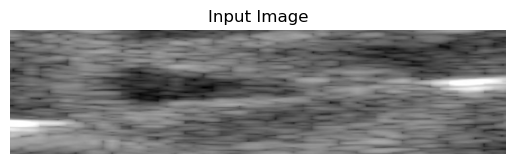

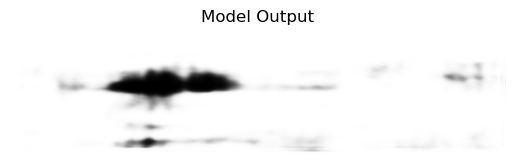

In [45]:
from onnx2torch import convert
import torch

onnx_model = onnx.load("CNN_C52v_2023March21.onnx")
torch_model = convert(onnx_model)

# Inference
image = r'Data\US_Test_2023April7\t3US94_738983_4.jpg'

from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms

# Path to your image
image_path = r'Data\US_Test_2023April7\t3US94_738983_4.jpg'

# Load image
image = Image.open(image_path).convert('RGB')  # or 'L' if grayscale

# Resize, normalize, and convert to tensor
transform = transforms.Compose([
    transforms.Resize((256, 1024)),       # Resize to match model input
    transforms.ToTensor(),                # Converts to tensor and scales to [0,1]
    transforms.Normalize([0.485, 0.456, 0.406],  # Replace with your model's mean
                         [0.229, 0.224, 0.225])  # and std if known
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension (1, 3, 256, 1024)

# Now you can pass it to the model
with torch.no_grad():
    output = torch_model(input_tensor)

print("Model Output:")
# print(output)

# plot the image and the output
import matplotlib.pyplot as plt
import numpy as np

import cv2

# Load the image using OpenCV
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB


# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.title("Input Image")
plt.show()

# plot the output
plt.imshow(output[0, 0].cpu().numpy(), cmap='gray')
plt.axis('off')  # Hide axes
plt.title("Model Output")
plt.show()


In [ ]:
"CNN_C52v_2023March21.onnx"

In [ ]:
import onnx

# Load the ONNX model
model = onnx.load("CNN_C52v_2023March21.onnx")

# Iterate through the nodes and rename duplicates
node_names = set()
for node in model.graph.node:
    if node.name in node_names:
        node.name = f"{node.name}_unique"
    node_names.add(node.name)

# Save the modified model
onnx.save(model, "CNN_C52v_2023March21_fixed_unique.onnx")

In [48]:
import torch
from torch import nn
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import onnx
from onnx2pytorch import ConvertModel
from onnx2pytorch.convert.operations import Add

# === 1. Load and preprocess image ===
image_path = r'Data\US_Test_2023April7\t3US94_738983_4.jpg'
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((256, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # Example normalization
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 256, 1024)

# === 2. Load ONNX model and convert to PyTorch ===
onnx_model_path = "CNN_C52v_2023March21.onnx"  # Update with your actual path
onnx_model = onnx.load(onnx_model_path)
torch_model = ConvertModel(onnx_model)

# === 3. Define SafeAdd ===
class SafeAdd(nn.Module):
    def forward(self, x, y):
        # Ensure both tensors are same shape by cropping to min size
        min_dim = [min(x.shape[i], y.shape[i]) for i in range(len(x.shape))]
        slices = tuple(slice(0, d) for d in min_dim)
        x_sliced = x[slices]
        y_sliced = y[slices]
        return x_sliced + y_sliced

# === 4. Replace Add with SafeAdd recursively ===
def replace_adds_with_safeadd(model):
    for name, module in model.named_children():
        if isinstance(module, Add):
            setattr(model, name, SafeAdd())
        else:
            replace_adds_with_safeadd(module)

replace_adds_with_safeadd(torch_model)

# === 5. Inference ===
torch_model.eval()
with torch.no_grad():
    output = torch_model(input_tensor)
    print("Output shape:", output.shape)

# === 6. Post-process output for visualization ===
output_np = output.squeeze().cpu().numpy()
if output_np.ndim == 3:
    output_np = output_np[0]  # take first channel if multiple

output_np = np.clip(output_np, 0, 1)
output_np = (output_np * 255).astype(np.uint8)
output_np = cv2.resize(output_np, (1024, 256))  # match input size
output_rgb = cv2.cvtColor(output_np, cv2.COLOR_GRAY2RGB)

# === 7. Visualize ===
plt.imshow(output_rgb)
plt.title("Model Output")
plt.axis("off")
plt.show()


Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum


TypeError: sum() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)
